<a href="https://colab.research.google.com/github/cloudmrhub/mroptimum-tools/blob/main/mroptimum_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MROptimum Tools — Notebook Guide

> **Purpose**: This notebook demonstrates how to install **mroptimum-tools**, load example MRI k‑space/noise data, and run common 2D reconstructions (RSS, B1, SENSE, GRAPPA). It also shows two SNR estimation strategies—**Analytical Method (AM)** and **Pseudo‑Multiple Replicas (PMR)**—and inspects noise properties (noise covariance, effective noise bandwidth). Finally, it compares AM vs PMR SNR maps and illustrates GRAPPA/SENSE g‑factor style analyses.

---

## What this notebook does

1. **Install runtime dependency**
   - Installs the latest `mroptimum-tools` directly from GitHub:
     ```bash
     pip install git+https://github.com/cloudmrhub/mroptimum-tools
     ```

2. **Import libraries & set up data**
   - Core modules from **mroptimum-tools**:
     - `mroAnalyticalMethodRSS`, `mroAnalyticalMethodB1`, `mroAnalyticalMethodSENSE`, `mroPseudoMultipleReplicas` (AM/PMR engines)
     - 2D recon helpers from `cmtools.cm2D` (`cm2DReconRSS`, `cm2DReconB1`, `cm2DReconSENSE`, `cm2DGFactorSENSE`, `cm2DReconGRAPPA`)
     - Utility functions from `cmtools.cm` (e.g., `mimicAcceleration2D` to create accelerated & reference k‑space for GRAPPA tests)
   - The notebook expects **signal k‑space** `S` and **noise k‑space** `N` arrays to be available (the example loader in the notebook prepares them).

---

## Repro/Environment

- Python ≥ 3.9 recommended
- Packages: `numpy`, `matplotlib`, plus `mroptimum-tools` (brings `cmtools`/`mrotools`)
- Run top‑to‑bottom in a clean kernel for best results

---


In [1]:
!pip install git+https://github.com/cloudmrhub/mroptimum-tools

  Cloning https://github.com/cloudmrhub/mroptimum-tools to /tmp/pip-req-build-37up2mng
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/mroptimum-tools /tmp/pip-req-build-37up2mng
  Resolved https://github.com/cloudmrhub/mroptimum-tools to commit 911098227b48034a5d90feeb159e4376885705e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/cloudmrhub/cloudmr-tools.git to /tmp/pip-install-lvo7_4l9/cmtools_253d5aa526f445a7b4922eca518f973b
  Running command git clone --filter=blob:none --quiet https://github.com/cloudmrhub/cloudmr-tools.git /tmp/pip-install-lvo7_4l9/cmtools_253d5aa526f445a7b4922eca518f973b
  Resolved https://github.com/cloudmrhub/cloudmr-tools.git to commit 88a701138cf6d02a356ded3ae8692d40a7a289ba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... don

In [2]:
# Load the data available for testing
from mrotools.mro import mroAnalyticalMethodRSS,mroAnalyticalMethodB1,mroAnalyticalMethodSENSE,mroPseudoMultipleReplicas


from pynico_eros_montin import pynico as pn

import numpy as np
import matplotlib.pyplot as plt

import cmtools
import os
import importlib.util

spec = importlib.util.find_spec('cmtools')
print(spec.submodule_search_locations)
if spec is not None:
    package_path = spec.submodule_search_locations[0]
    package_path=os.path.join(package_path,'testdata.pkl')
else:
    print("cmtools module not found")

a=pn.Pathable(package_path)
A=a.readPkl()

S=A[0]["signal"]
N=A[0]["noise"]


['/usr/local/lib/python3.12/dist-packages/cmtools']


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----
cmOutput created but Deprecated, use cmaws.cmrOutput instead
----
calculateCoilsSensitivityMask2D espirit


/usr/local/lib/python3.12/dist-packages/cmtools/cm2D.py:342: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  snr[irow,icol] = np.abs(np.sqrt(2*(A @ B)))


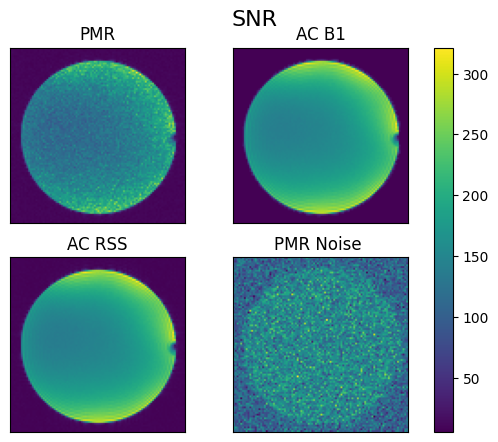

In [3]:

from cmtools.cm2D import cm2DReconRSS


L2=mroPseudoMultipleReplicas()
L=cm2DReconRSS()
L2.numberOfReplicas=50
L.setNoiseKSpace(N)
L.setSignalKSpace(S)
L2.reconstructor=L

plt.subplot(221)
plt.imshow(np.abs(L2.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR')



R2=mroAnalyticalMethodB1()
R2.setNoiseKSpace(N)
R2.setSignalKSpace(S)
R2.setReferenceKSpace(S)
R2.setMaskCoilSensitivityMatrixBasedOnEspirit()
plt.subplot(222)
plt.imshow(np.abs(R2.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('AC B1')


R=mroAnalyticalMethodRSS()
R.setNoiseKSpace(N)
R.setSignalKSpace(S)
plt.subplot(223)
plt.imshow(np.abs(R.getOutput()))
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('AC RSS')


plt.subplot(224)
plt.imshow(L2.getSNRDenumerator())
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title('PMR Noise ')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.colorbar(plt.gcf().axes[0].images[0], ax=plt.gcf().axes)

plt.suptitle("SNR", fontsize=16)

plt.show()

/usr/local/lib/python3.12/dist-packages/cmtools/cm.py:369: ComplexWarning: Casting complex values to real discards the imaginary part
  coeff[itemp,jtemp] = cov[itemp,jtemp]/np.sqrt(cov[itemp,itemp]*cov[jtemp,jtemp])


calculateCoilsSensitivityMask2D reference 
calculateCoilsSensitivityMask2D reference 


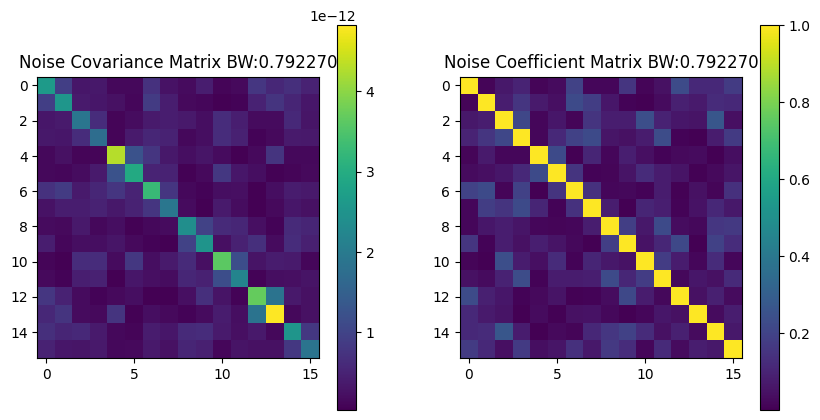

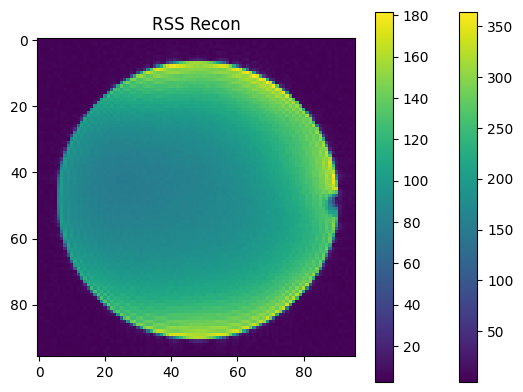

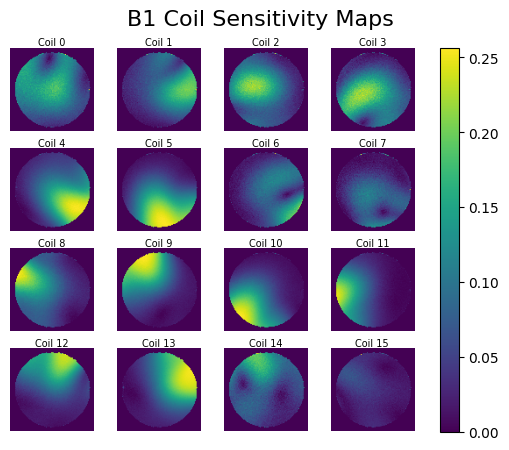

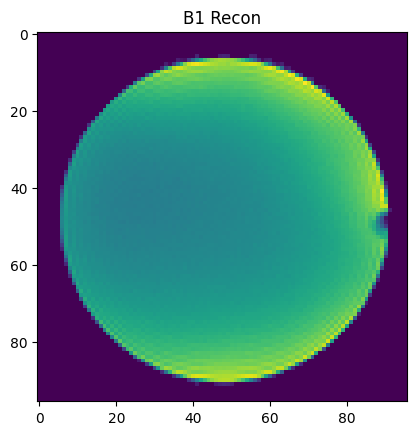

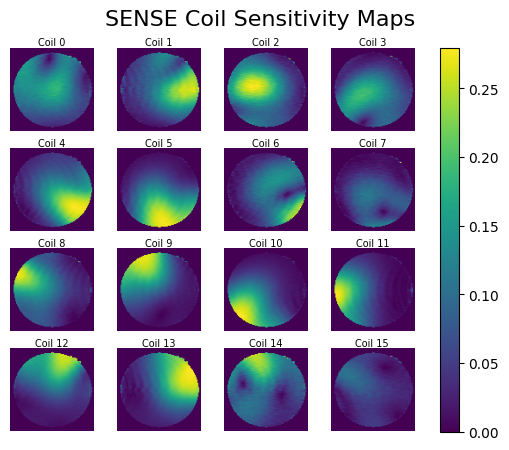

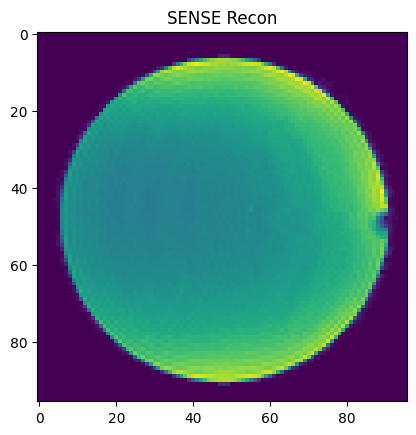

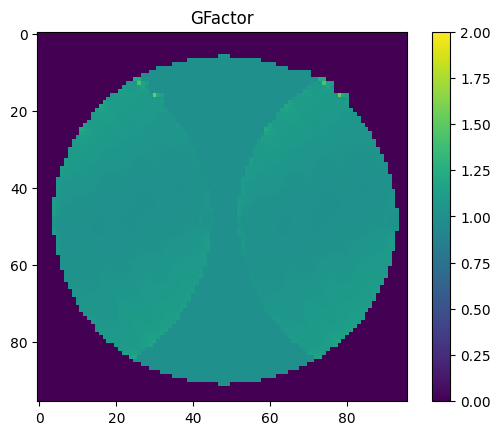

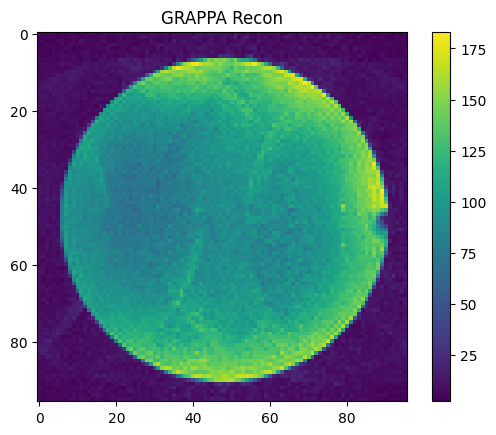

In [4]:
from cmtools.cm2D import cm2DReconRSS, cm2DReconB1,cm2DReconSENSE,cm2DGFactorSENSE,cm2DReconGRAPPA
import cmtools.cm as cm


L=cm2DReconRSS()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)

NBW=L.getNoiseBandWidth()

nc2=L.getNoiseCovariance()
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(np.abs(nc2))
plt.colorbar()
plt.title(f'Noise Covariance Matrix BW:{NBW:03f}')

plt.subplot(122)
plt.imshow(np.abs(L.getNoiseCovarianceCoefficients()))
plt.colorbar()
plt.title(f'Noise Coefficient Matrix BW:{NBW:03f}')


p=L.getPrewhitenedSignal()
plt.figure()
plt.imshow(np.abs(p[:,:,0]))
plt.colorbar()
plt.title('Prewhitened Kspace First Coil')

im=L.getOutput()

import matplotlib.pyplot as plt

plt.imshow(im)
plt.colorbar()
plt.title('RSS Recon')

L=cm2DReconB1()
L.setSignalKSpace(S)
L.setNoiseKSpace(N)
L.setReferenceKSpace(S)
L.prepareCoilSensitivityMatrixPlot(title='B1 Coil Sensitivity Maps')
plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.title('B1 Recon')



# acceleration frequency and phase
FA=1
PA=2
# autocalibrationlines
ACL=20
L=cm2DReconSENSE()
L.setAcceleration([FA,PA])
US,REF=cm.mimicAcceleration2D(S,[FA,PA],ACL=[np.nan,ACL])

L.setSignalKSpace(US)
L.setNoiseKSpace(N)
L.setReferenceKSpace(REF)
L.setAutocalibrationLines(ACL)

L.prepareCoilSensitivityMatrixPlot(title='SENSE Coil Sensitivity Maps')

plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.title('SENSE Recon')



# transform in Kellman!!!
L.__class__=cm2DGFactorSENSE
plt.figure()
plt.imshow(np.abs(L.getOutput()),vmin=0,vmax=2)
plt.colorbar()
plt.title('GFactor')



FA=1
PA=4
ACLF=20
ACLP=20
GK=[2,5]

US,REF=cm.mimicAcceleration2D(S,[FA,PA],[ACLF,ACLP])
L=cm2DReconGRAPPA()
L.setSignalKSpace(US)
L.setAcceleration([FA,PA])
L.setAutocalibrationLines([ACLF,ACLP])
L.setNoiseKSpace(N)
L.setGRAPPAKernel(GK)
L.setReferenceKSpace(REF)

plt.figure()
plt.imshow(np.abs(L.getOutput()))
plt.colorbar()
plt.title('GRAPPA Recon')
plt.show()

SNR GRAPPA AM vs PMR

----
cmOutput created but Deprecated, use cmaws.cmrOutput instead
----


/usr/local/lib/python3.12/dist-packages/cmtools/cm2D.py:342: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  snr[irow,icol] = np.abs(np.sqrt(2*(A @ B)))


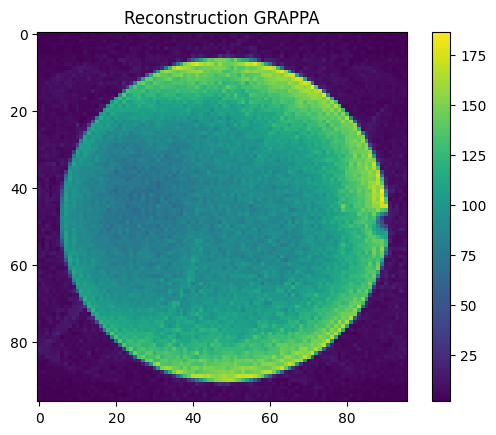

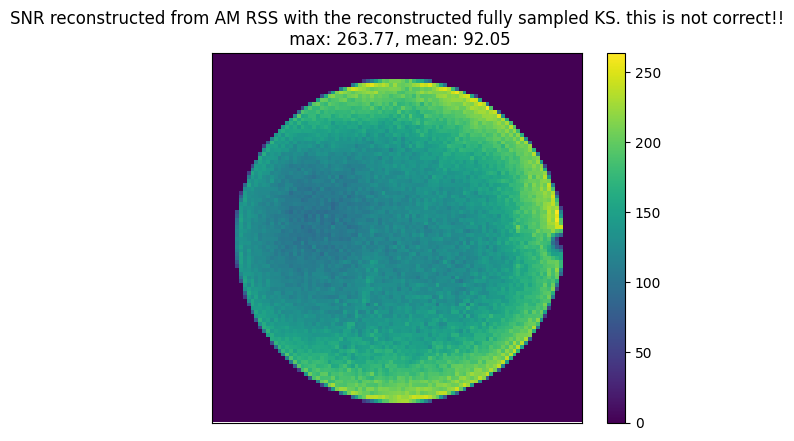

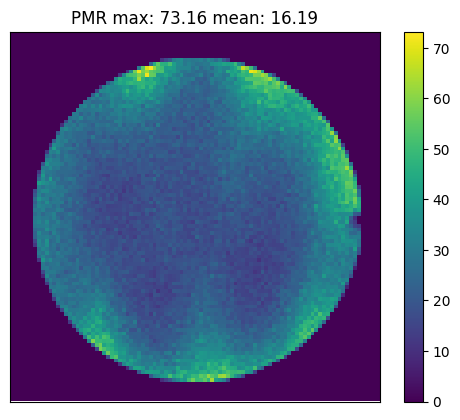

In [14]:

import cmtools.cm2D as cm2D

mask=np.abs(ss)>30


# configure the reconstruction
FA=1 #frequency encoding acceleration
PA=4 #phase encoding acceleration
#ACL lines
ACLF=48
ACLP=48
# grappa kernel
GK=[5,5]
# mimic an accelerated kspace grappa from a fully sample
US,REF=cm.mimicAcceleration2D(S,[FA,PA],[ACLF,ACLP])
L=cm2D.cm2DReconGRAPPA()
L.setSignalKSpace(US)
L.setAcceleration([FA,PA])
L.setAutocalibrationLines([ACLF,ACLP])
L.setNoiseKSpace(N)
L.setGRAPPAKernel(GK)
L.setReferenceKSpace(REF)



plt.figure()
ss=L.getOutput()
plt.imshow(np.abs(ss))
plt.colorbar()
plt.title(f'Reconstruction GRAPPA')

# pmr reconstruciton
L2=mroPseudoMultipleReplicas()
L2.numberOfReplicas=100
L.setNoiseKSpace(N)
L.setSignalKSpace(US)
# image reconstructor
L2.reconstructor=L

# Let's see the range of  values of the SNR of the restored kspace (fully sampled after GRAPPA) if reconstructed naively with RSS Kellman
L3 = cm2D.cm2DKellmanRSS()
# restored kspace
GKf=L.getSignalKSpaceGRAPPAFullysampled()

L3.setSignalKSpace(GKf)
L3.setPrewhitenedSignal(GKf)
L3.setNoiseCovariance(np.eye(GKf.shape[-1]))


plt.figure()

am=np.abs(L3.getOutput())*mask
plt.imshow(am)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title(f'SNR reconstructed from AM RSS with the reconstructed fully sampled KS. this is not correct!!\n max: {am.max():.2f}, mean: {am.mean():.2f}' )
plt.colorbar()

pmr=np.abs(L2.getOutput())*mask
plt.figure()

plt.imshow(pmr)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
plt.title(f'PMR max: {pmr.max():.2f} mean: {pmr.mean():.2f}')
plt.colorbar()
plt.show()



/tmp/ipython-input-1389831762.py:28: RuntimeWarning: divide by zero encountered in divide
  Igf=1.0/Gfactor*mask
/tmp/ipython-input-1389831762.py:28: RuntimeWarning: invalid value encountered in multiply
  Igf=1.0/Gfactor*mask


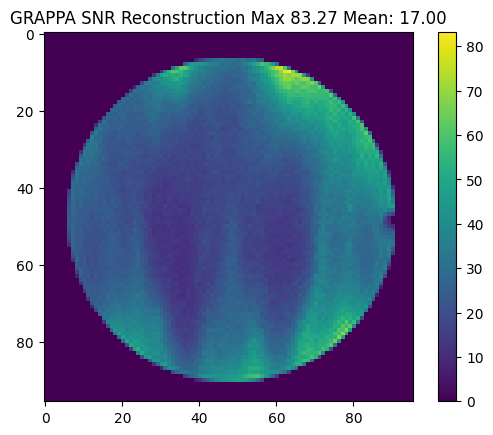

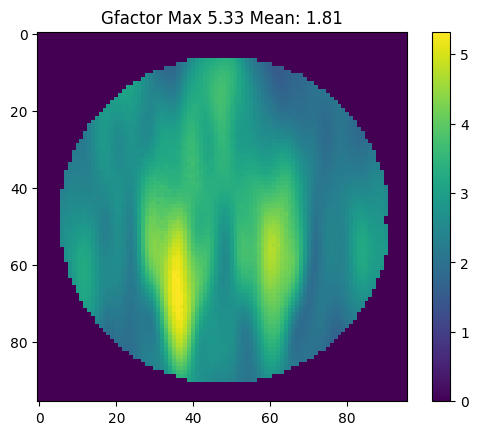

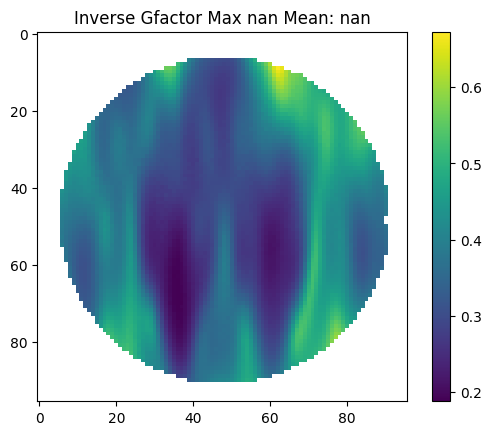

In [17]:
#now Let's use the new calss GRAPPA AM
from mrotools.mro import mroAnalyticalMethodGRAPPA

US,REF=cm.mimicAcceleration2D(S,[FA,PA],[ACLF,ACLP])
GG=mroAnalyticalMethodGRAPPA()
GG.setSignalKSpace(US)
GG.setReferenceKSpace(REF)
GG.setAcceleration([FA,PA])
GG.setAutocalibrationLines([ACLF,ACLP])
GG.setNoiseKSpace(N)
GG.setGRAPPAKernel(GK)
GG.setReferenceKSpace(REF)

Gfactor=GG.getGFactor()*mask
amg=np.abs(GG.getOutput())*mask

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(amg)
plt.colorbar()
plt.title(f'GRAPPA SNR Reconstruction Max {amg.max():.2f} Mean: {amg.mean():.2f}')

plt.figure()
plt.imshow(Gfactor)
plt.colorbar()
plt.title(f'Gfactor Max {Gfactor.max():.2f} Mean: {Gfactor.mean():.2f}')

Igf=1.0/Gfactor*mask
plt.figure()
plt.imshow(Igf)
plt.colorbar()
plt.title(f'Inverse Gfactor Max {Igf.max():.2f} Mean: {Igf.mean():.2f}')


plt.show()